#MICROSOFT’S NEW MOVIE STUDIO ANALYSIS



#Microsoft’s Movie Studio Analysis
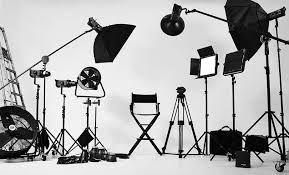
###Overview

This project majors on the movie industry.Therefore, the analysis will show what we will need to focus on in order to have a successful movie studio.According to the data base that is going to be used we will get to know which genres perform best,a reasonable runtime for the movies,family-friendly films to release and the best time to release the  movies.Microsoft’s New Movie Studio can use this analysis to create fruitfil movies and to help the organisation perform better.

###Business Problem
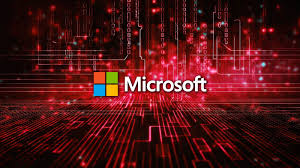

This analysis may be able to show us which types of films will perform best at the movie studio.Furthermore, it will provide a suitable runtime that is ideal for the  audience engagement, genres that tend to generate the highest revenue and when  movies are best released to maximize impact.Using the dataset below, I will generate a useful data that will help in creating a successful studio.

##Data Understanding
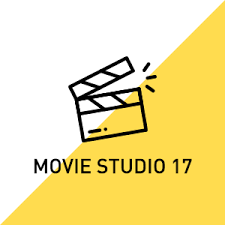

This projects' dataset has a rich and relevant basis for analyzing movie performance trends over time, by genre, and by studio.It is also linked to the audience ratings.With the perfect cleaned data, meaningful data can be made which will give insightful exploration into what will make this movie studio both profitable and well-received.

In [179]:
import pandas as pd

#Load the datasets
movie_gross= pd.read_csv('bom.movie_gross.csv.gz')
imdb_basics= pd.read_table('title.basics.tsv.gz', sep='\t', low_memory=False)
imdb_ratings= pd.read_csv('imdb.title.ratings.csv.gz')

###Movie gross,title basic and title ratings data
The IMDb and BOM datasets include a variety of titles, gross etc ,from the year 2009 to 2019.

In [180]:
movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [181]:
imdb_basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Poor Pierrot,Pauvre Pierrot,0,1892,\N,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,Short


In [182]:
imdb_ratings.head()

,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


##Data Preparations
###Data Cleaning
Using the datasets(basics,ratings and gross), I make it easier to work with them by normalizing,dropping,filling,adding columns amongst others.A combinination of the three datasets was also needed for feature engineeering,analysis and visualizations.I will first clean each data separately then merge IMDd basics with BOM then afterwards merge IMDb ratings.Finally i will be dropping unnecessarry rows,filling in some data to avoid loosing too much data and creating or adding columns where needed.This will help me analyse data without being limited.

In [183]:
from urllib.request import UnknownHandler
#First:Clean BOM data

#Keep only domestic gross
bom_gross = movie_gross[movie_gross['domestic_gross'].notnull()].copy()

#Clean gross columns (convert to numeric)
bom_gross['domestic_gross'] = pd.to_numeric(bom_gross['domestic_gross'], errors='coerce')
bom_gross['foreign_gross'] = pd.to_numeric(bom_gross['foreign_gross'], errors='coerce')

#Normalize title column for easier merging
bom_gross['title'] = bom_gross['title'].str.lower().str.strip()

#Second: Clean IMDb Basics

#Keep movies
imdb_basics = imdb_basics[imdb_basics['titleType'] == 'movie'].copy()

#Normalize primaryTitle
imdb_basics['primaryTitle'] = imdb_basics['primaryTitle'].str.lower().str.strip()

#Third: Merge datasets

# Merge BOM with IMDb basics (left join to keep all BOM movies)
merged = pd.merge(bom_gross, imdb_basics, left_on='title', right_on='primaryTitle', how='left')

# Merge with IMDb ratings
merged = pd.merge(merged, imdb_ratings, on='tconst', how='left')

# Drop rows
merged = merged.dropna(subset=['genres'])

#Fill NaNs with 0
merged['averagerating'] = merged['averagerating'].fillna(0)
merged['foreign_gross'] = merged['foreign_gross'].fillna(0)
merged['studio'] = merged['studio'].fillna(UnknownHandler)

# Create useful columns
merged['startYear'] = pd.to_numeric(merged['startYear'], errors='coerce')
merged = merged[merged['startYear'].notnull()]
merged['startYear'] = merged['startYear'].astype(int)
merged = merged[merged['numvotes'] >= 100]

# Add 'decade' column
merged['decade'] = (merged['startYear'] // 10) * 10

###Feature Engineering
I introduced `total_gross` feature in order to analyse the total money earned from `domestic_gross` and `foreign_gross` features.

In [184]:
merged['total_gross']=merged['domestic_gross']+merged['foreign_gross']

###Data analysis

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
import numpy as np


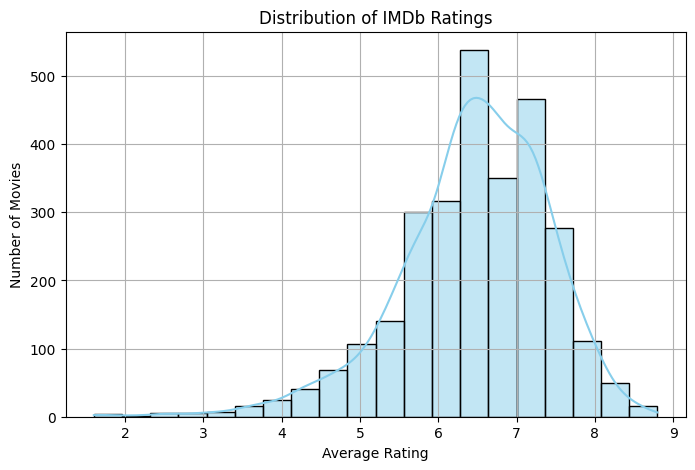

In [186]:
#Plot a histogram showing movie ratings
plt.figure(figsize=(8, 5))
sns.histplot(merged['averagerating'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of IMDb Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.show()

The peak is at around 5-6 which means most movies are rated average whereas a few are given low ratings.

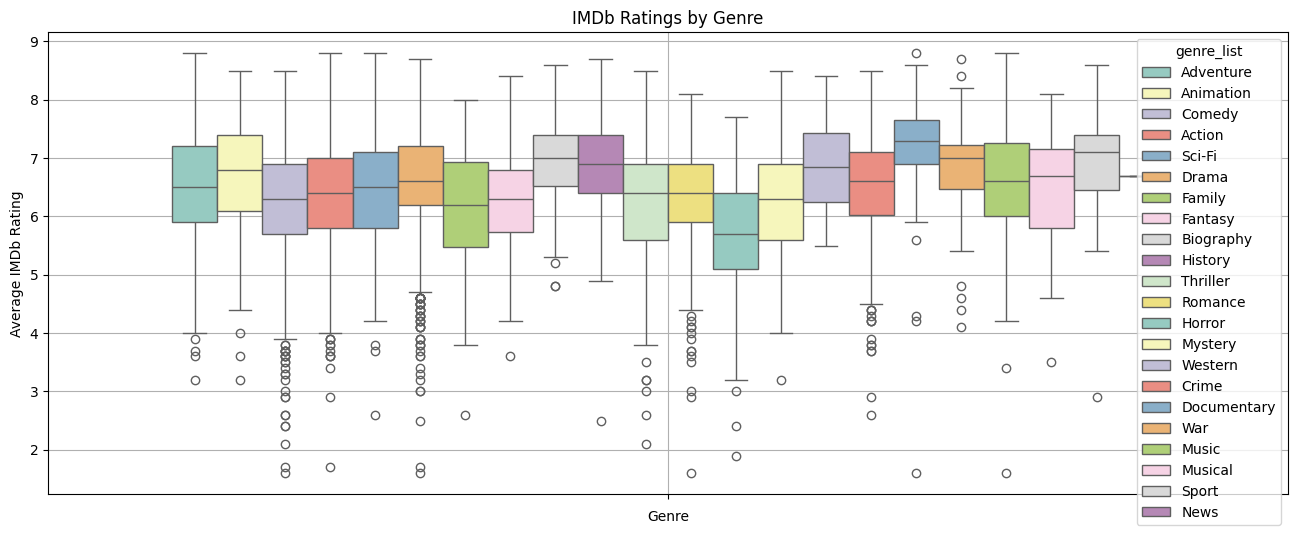

In [187]:
# Explode the genre list
merged['genre_list'] = merged['genres'].str.split(',')
genre_ratings = merged.explode('genre_list')
genre_ratings = genre_ratings.dropna(subset=['genre_list', 'averagerating'])

#Plot a box plot of ratings by genres
plt.figure(figsize=(16, 6))
sns.boxplot(data=genre_ratings, hue='genre_list', y='averagerating',  palette='Set3')

plt.title('IMDb Ratings by Genre')
plt.xlabel('Genre')
plt.ylabel('Average IMDb Rating')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Some observations made amongst others include:

 1.Documentaries have the highest ranking.

 2.Horror movies has the lowest ranking.

 3.Genres with a wider spread are poralizing (ie. they maybe loved or not) while genres with a narrower spread are loved.

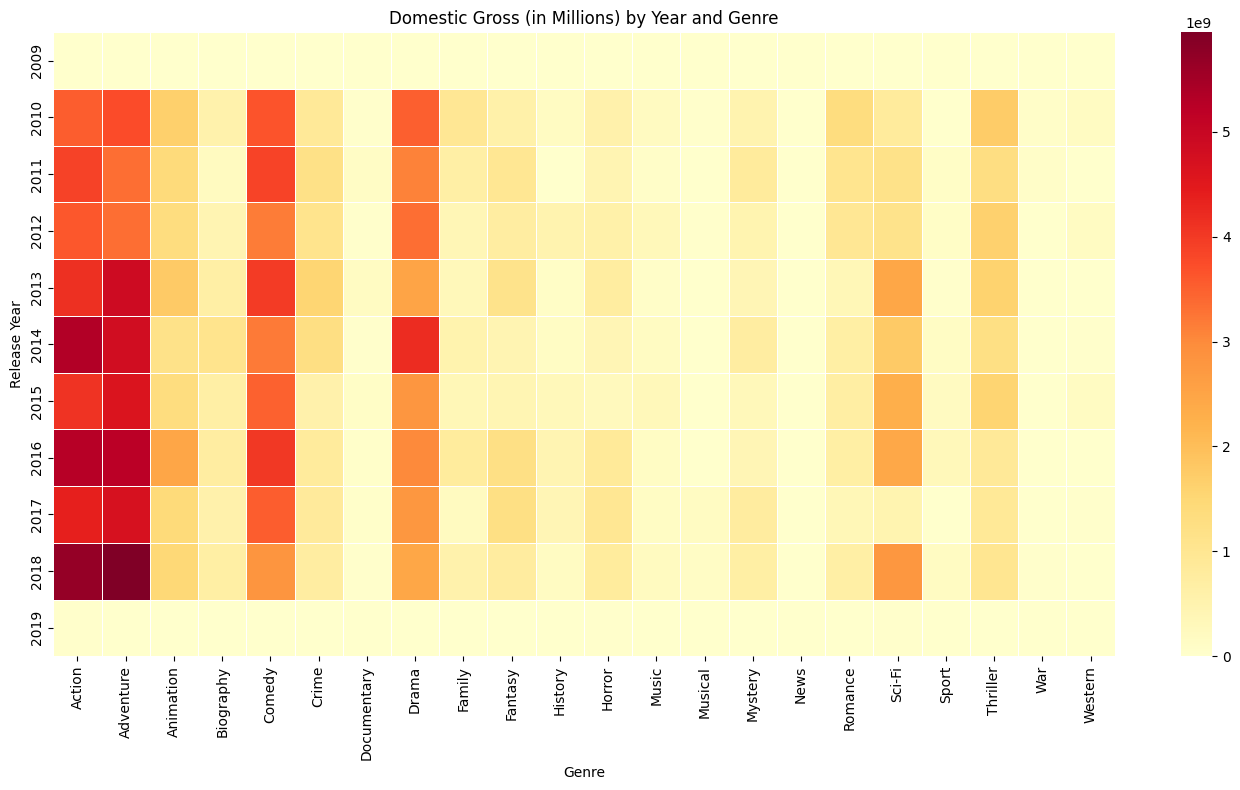

In [188]:
#Create a pivot table
pivot = genre_ratings.pivot_table(index='startYear', columns='genre_list', values='domestic_gross', aggfunc='sum', fill_value=0)

#Plot a heatmap of gross by year and genre
plt.figure(figsize=(14, 8))
sns.heatmap(pivot, cmap='YlOrRd', linewidths=0.5)

plt.title('Domestic Gross (in Millions) by Year and Genre')
plt.xlabel('Genre')
plt.ylabel('Release Year')
plt.tight_layout()
plt.show()


Genres such as action and adventure have the highest box offices revenue.There is a decline in genres like war and western in each year.In the year 2019 there was low box office revenue in all genres.

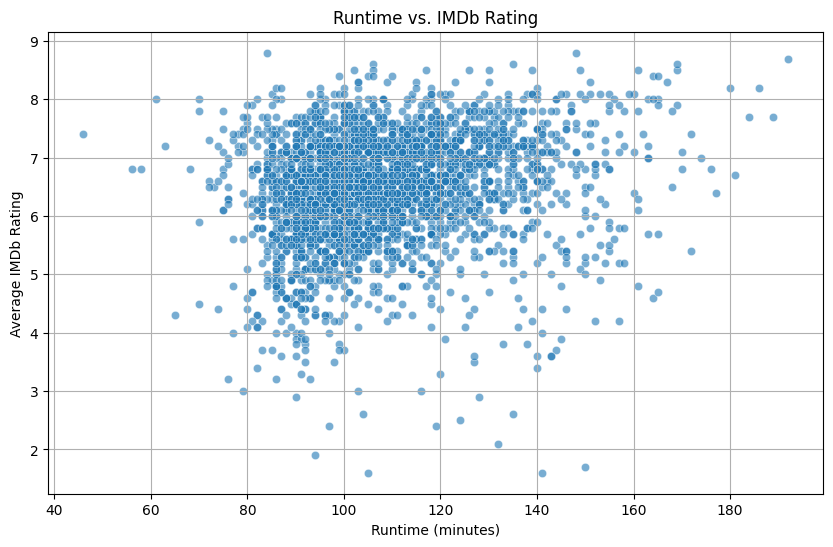

In [189]:
#Ensure data is clean
runtime_df = merged.dropna(subset=['runtimeMinutes', 'averagerating'])
runtime_df['runtimeMinutes'] = pd.to_numeric(runtime_df['runtimeMinutes'], errors='coerce')
runtime_df = runtime_df[runtime_df['runtimeMinutes'] > 0]
runtime_df = runtime_df[runtime_df['runtimeMinutes'] <= 240]

#Plot a scatter plot of ratings vs runtime
plt.figure(figsize=(10, 6))
sns.scatterplot(data=runtime_df, x='runtimeMinutes', y='averagerating', alpha=0.6)
runtime_df['runtime_bin'] = pd.cut(runtime_df['runtimeMinutes'], bins=range(0, 241, 20))
plt.title('Runtime vs. IMDb Rating')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Average IMDb Rating')
plt.grid(True)
plt.show()


Most popular films are around 90–120 minutes and receive average IMDb ratings between 6 and 7.

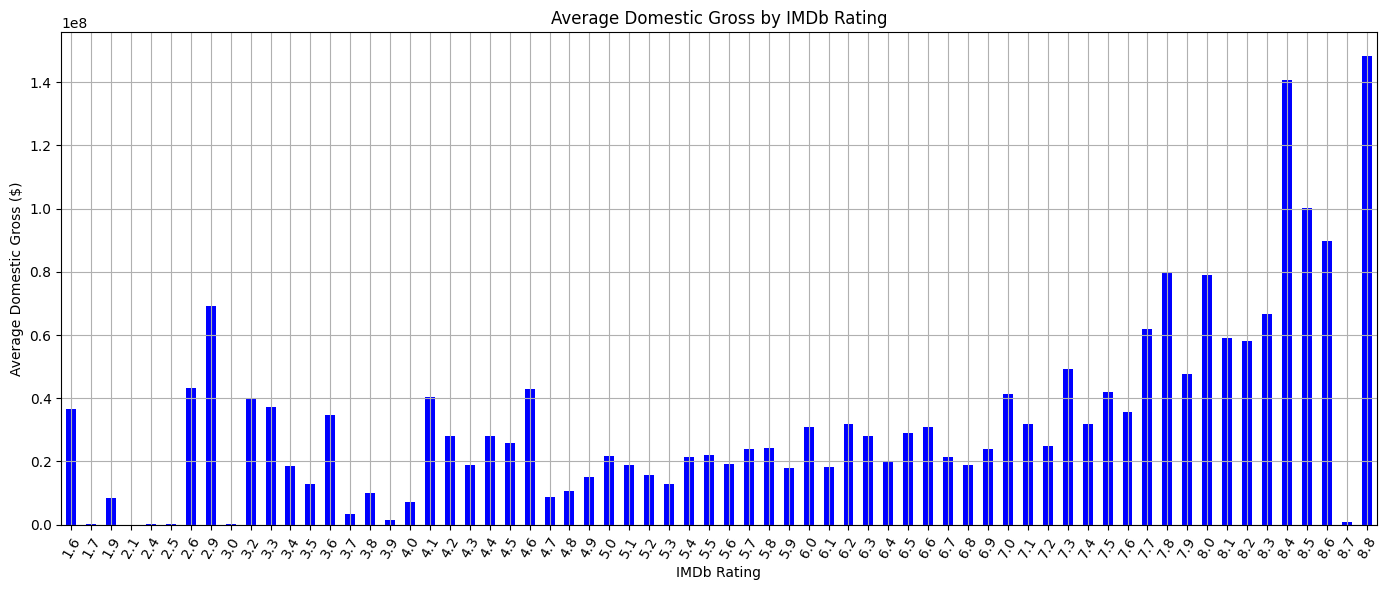

In [190]:
#Ensure the data is clean
rating_gross = merged.dropna(subset=['averagerating', 'domestic_gross'])
rating_gross['rounded_rating'] = rating_gross['averagerating'].round(1)
avg_gross_by_rating = rating_gross.groupby('rounded_rating')['domestic_gross'].mean().sort_index()

#Plot a barchart of average gross by ratings
plt.figure(figsize=(14, 6))
avg_gross_by_rating.plot(kind='bar', color='blue')

plt.title('Average Domestic Gross by IMDb Rating')
plt.xlabel('IMDb Rating')
plt.ylabel('Average Domestic Gross ($)')
plt.grid(True)
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()


Movies with higher ratings earn more than the one the ones that have low rating.The peak is at 8.4 and 8.6. Movies with ratings between 4-5 perform poorly and therefore they get a low income.

###Conclusion
This analysis leads to some recommendations for improving performances of Microsoft Movie Studio:

- Genres Influence Both Ratings and Revenue
- Explore international box office data.
- Identify emerging sub-genres.
- Longer Runtimes Correlate Slightly with Higher Ratings
